# Yelp Coffee Recommendations

## Introduction

University students have a reputation for surviving on coffee, especially during finals, so I was inspired to do an analysis of the coffee shops surrounding LSE. While there are cafes on campus, many students want to go off campus for a change of scenery, and potentially for better coffee. I wanted to examine the spread of the attributes of the coffee shops nearest to campus, and discover if there were any meaningful patterns. Are the coffee shops more expensive near LSE? Are they higher rated the more north in London you go? After exploring the data, I wanted to create a simple recommendation system to match students with the right cafe for them, based on their personal preferences.


## Data Collection and Cleaning

I used the Yelp Fusion API to scrape the information I needed from the coffee shops nearest to LSE. I used the coordinates of the LSE Library as the initial search location, and pulled the nearest 150 coffee shops.

In [23]:
# LSE library coordinates: 51.514859, -0.115740

In [6]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import shapefile

%matplotlib inline

In [7]:
api_key = 'insert user API Key here'
headers = {'Authorization': 'Bearer %s' % api_key}
url = 'https://api.yelp.com/v3/businesses/search'
offsets = [0,51,101]
biz = []
for i in range(3):
    params = {'term':'coffee','latitude':51.514859,'longitude':-0.115740,'limit':50,'offset':offsets[i]}
    req = requests.get(url, params=params, headers=headers)
    parsed = json.loads(req.text)
    businesses = parsed["businesses"]
    biz.append(businesses)

Once I got the parsed information on the nearest 150 coffee shops, I then pulled the attributes that I wanted to use for this analysis. I chose name, rating (out of 5 stars), distance (from the LSE library, in meters), the number of reviews for the coffee shop, the price (rated from £ to ££££), and the latitude and longitude. Some of the attributes that I excluded were street address, phone number, Yelp URL, and other attributes that I did not feel were relevant to my initial questions.

The data was very clean, however, not all of the coffee shops had a price rating. I excluded these coffee shops when creating my initial data frame, and was left with 117 cafes. The rest of the data looks consistent with my expectations. The ratings did not go lower than 1.0 or higher than 5.0, the radius from LSE maxxed out at around 3300 meters (about a 30-40 minute walk), there were no negative counts for reviews, and the latitude and longitude did not seem to vary too much from the LSE Library coordinates.

In [8]:
coffees = []

for b in biz:
    for business in b:
        tempkeys = business.keys()
        #print(tempkeys)
        if 'price' in tempkeys:
            coffees.append([business["name"],business["rating"],business["distance"],business['review_count'],
                            business["price"],business['coordinates']['latitude'],business['coordinates']['longitude']])

cafes = pd.DataFrame(coffees, columns=["Name","Rating","Distance","Reviews","Price","Latitude","Longitude"])
cafes=cafes.dropna()
print(cafes.describe())

           Rating     Distance     Reviews    Latitude   Longitude
count  117.000000   117.000000  117.000000  117.000000  117.000000
mean     4.363248  1357.794126   48.239316   51.516743   -0.115639
std      0.357336   710.292920   73.977006    0.008778    0.016912
min      3.500000   267.464861    2.000000   51.498046   -0.156689
25%      4.000000   776.605884   10.000000   51.512119   -0.126917
50%      4.500000  1316.768653   25.000000   51.516013   -0.119714
75%      4.500000  1822.543745   52.000000   51.523029   -0.102642
max      5.000000  3312.624884  579.000000   51.542644   -0.076815


I did want to transform the price column from strings that contained the pound symbol to a more useable value. I simply replaced the strings with the appropriate integer to represent the price rating: 1 being the cheapest and 4 being the most expensive.

In [9]:
cafes = cafes.replace('£',1)
cafes = cafes.replace('££',2)
cafes = cafes.replace('£££',3)
cafes = cafes.replace('££££',4)
print(cafes.describe())

           Rating     Distance     Reviews       Price    Latitude   Longitude
count  117.000000   117.000000  117.000000  117.000000  117.000000  117.000000
mean     4.363248  1357.794126   48.239316    1.581197   51.516743   -0.115639
std      0.357336   710.292920   73.977006    0.619222    0.008778    0.016912
min      3.500000   267.464861    2.000000    1.000000   51.498046   -0.156689
25%      4.000000   776.605884   10.000000    1.000000   51.512119   -0.126917
50%      4.500000  1316.768653   25.000000    2.000000   51.516013   -0.119714
75%      4.500000  1822.543745   52.000000    2.000000   51.523029   -0.102642
max      5.000000  3312.624884  579.000000    4.000000   51.542644   -0.076815


## Data Visualization

Visiualizing the columns (other than latitude and longitude), there do not seem to be any outliers, and the data continues to look consistent with my expectations. Most of the coffee shops have ratings of 4.0 and 4.5, there are only a few cafes listed that are relatively far from LSE, most cafes are not that expensive, and the majority of cafes have a small number of reviews.

array([[<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'Distance'}>],
       [<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Reviews'}>]], dtype=object)

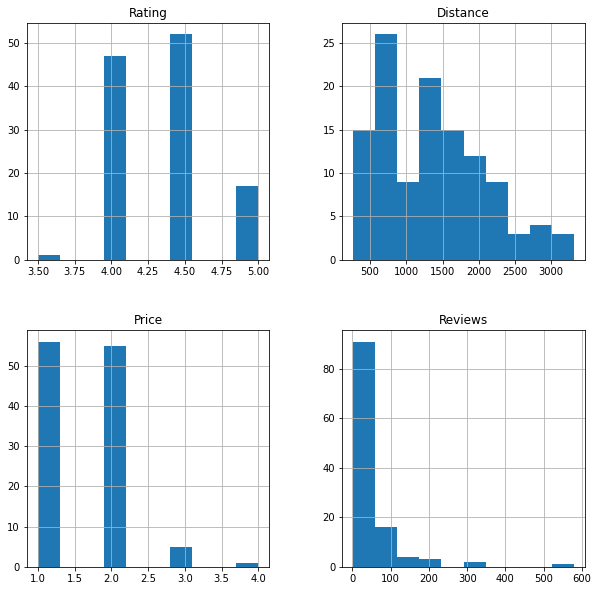

In [10]:
# distributions of ratings, distance, and number of reviews
colors = ['red', 'green', 'blue', 'orange']
cafes.hist(column=["Rating", "Distance", "Price", "Reviews"], figsize=(10,10))

After this initial vizualization to check that the data was fully clean, I added one more row to the dataframe to represent the LSE Library. I moved on to geographic visualizations, so I wanted to be able to compare the locations of the coffee shops to campus. Once this was added to the dataframe, I created a new dataframe that had points for each cafe made from their latitude and longitude, so they could be visualized on a map.

In [11]:
lse_library = {"Name":"LSE","Rating":0,"Distance":0,"Reviews":0,"Price":0,"Latitude":51.514859,"Longitude":-0.115740}
lcafes = cafes.append(lse_library, ignore_index=True)

geom = [Point(xy) for xy in zip(lcafes['Longitude'],lcafes['Latitude'])]
crs = 'epsg:4326'
g_cafes = gpd.GeoDataFrame(lcafes, crs=crs, geometry=geom)
g_cafes.tail()

/var/folders/1w/cdddqf211c75yxwq370l1n5m0000gn/T/ipykernel_83305/2174511536.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lcafes = cafes.append(lse_library, ignore_index=True)


,Name,Rating,Distance,Reviews,Price,Latitude,Longitude,geometry
113,Appestat,4.0,2350.931692,19,2,51.534832,-0.104272,POINT (-0.10427 51.53483)
114,Paper and Cup,4.5,2974.757689,24,1,51.526220,-0.076815,POINT (-0.07681 51.52622)
115,The Poetry Cafe,3.5,569.468302,17,2,51.515061,-0.123963,POINT (-0.12396 51.51506)
116,Mercato Metropolitano,4.5,2201.283155,43,2,51.498298,-0.098314,POINT (-0.09831 51.49830)
117,LSE,0.0,0.000000,0,0,51.514859,-0.115740,POINT (-0.11574 51.51486)


The shapefile that the UK government makes accessible for London includes all 32 boroughs. However, since I capped my search at the 150 closest cafes, they are not located in all 32 boroughs. I initially did a visualization of all the cafes on the large map, and then recorded which boroughs they were located in. I then extracted the subset of shapes that were the boroughs I needed, so that I could create more comprehensible visualizations.

<AxesSubplot:>

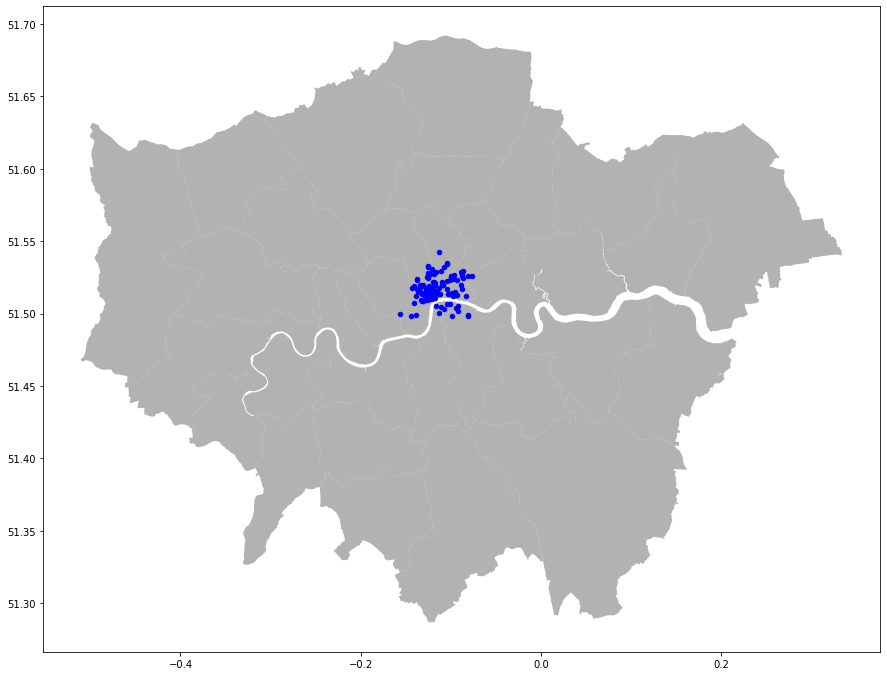

In [13]:
london_map = gpd.read_file('./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
lm = london_map.to_crs(epsg=4326)
sf=shapefile.Reader('./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
shape_records = sf.shapeRecords()

fig,ax = plt.subplots(figsize = (15,15))
lm.plot(ax=ax, alpha=0.6,color="grey")
g_cafes.plot(ax=ax, markersize=20, color="blue")

In [14]:
boroughs = ["Lambeth","Southwark","Westminster","Camden","Tower Hamlets","Islington","Hackney","City of London"]
b = []
for s in shape_records:
    if s.record[0] in boroughs:
        b.append(s.shape)
lm = lm[lm["NAME"].isin(boroughs)]
lm

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
10,Lambeth,E09000022,2724.940,43.927,T,None,None,"POLYGON ((-0.12846 51.48505, -0.12843 51.48506..."
11,Southwark,E09000028,2991.340,105.139,T,None,None,"POLYGON ((-0.10892 51.50844, -0.10889 51.50845..."
24,Westminster,E09000033,2203.005,54.308,T,None,None,"POLYGON ((-0.15000 51.48548, -0.15009 51.48590..."
25,Camden,E09000007,2178.932,0.000,T,None,None,"POLYGON ((-0.14242 51.56912, -0.14250 51.56901..."
26,Tower Hamlets,E09000030,2157.501,179.707,T,None,None,"POLYGON ((-0.07938 51.50784, -0.07935 51.50791..."
27,Islington,E09000019,1485.664,0.000,T,None,None,"POLYGON ((-0.13839 51.55686, -0.13852 51.55701..."
28,Hackney,E09000012,1904.902,0.000,T,None,None,"POLYGON ((-0.09766 51.57365, -0.09756 51.57368..."
32,City of London,E09000001,314.942,24.546,T,None,None,"POLYGON ((-0.11157 51.51075, -0.11159 51.51091..."


Once I had the appropriately sized map, I first looked at the general spread of coffee shops around the LSE Library.

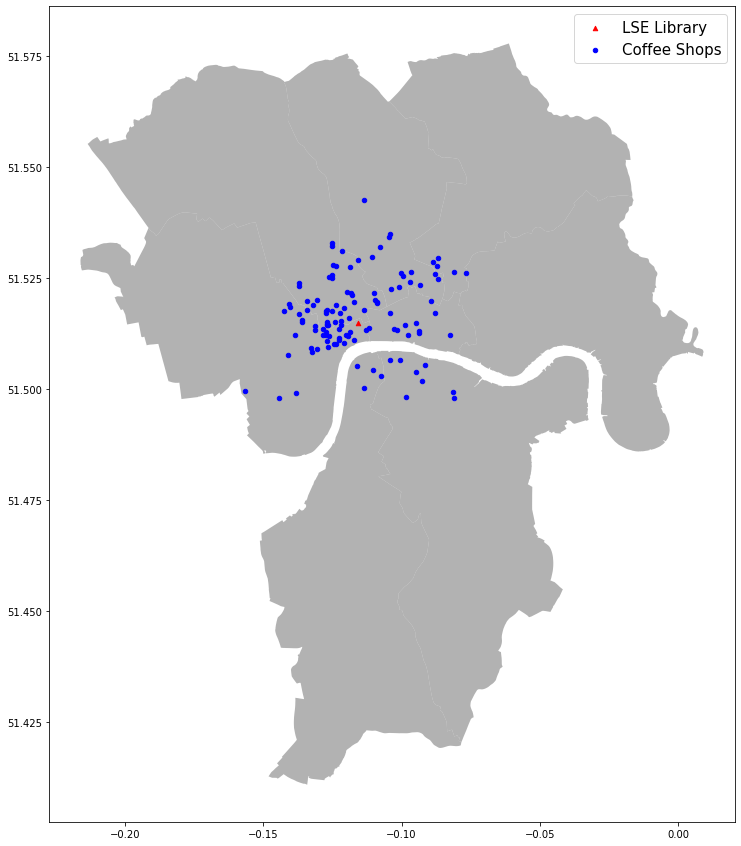

In [15]:
fig,ax = plt.subplots(figsize = (15,15))
lm.plot(ax=ax, alpha=0.6,color="grey")
g_cafes[g_cafes["Name"]=='LSE'].plot(ax=ax, markersize=20, color="red",marker="^", label="LSE Library")
g_cafes[g_cafes["Name"]!='LSE'].plot(ax=ax, markersize=20, color="blue", label="Coffee Shops")
plt.legend(prop={"size":15})

I then looked at the spread of the prices of the coffee shops around LSE. There doesn't seem to be any strong pattern of price level geographically, other than the more expensive cafes are relatively close to the Thames.

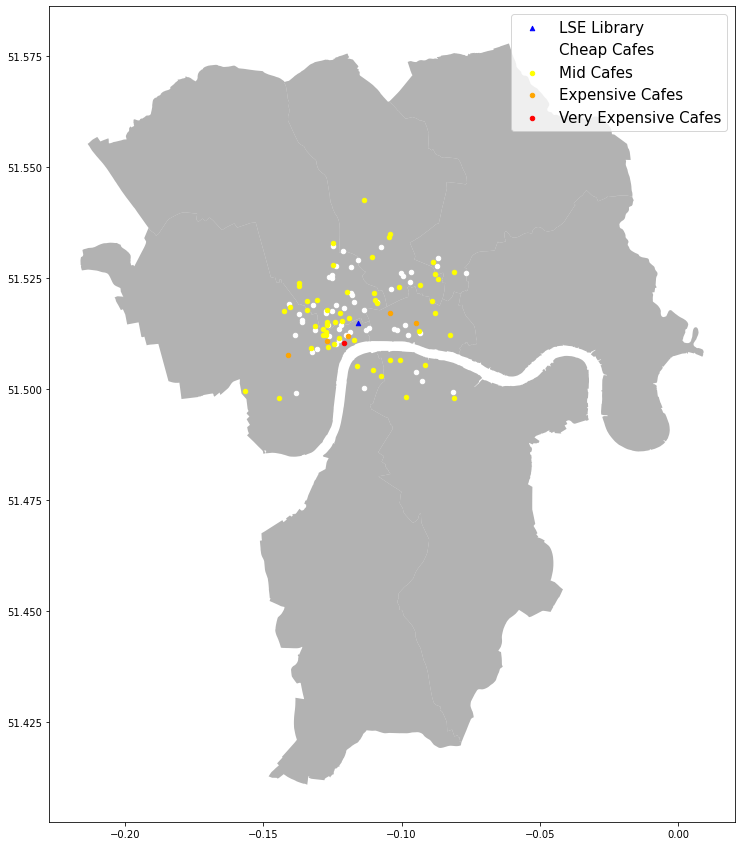

In [17]:
fig,ax = plt.subplots(figsize = (15,15))
lm.plot(ax=ax, alpha=0.6,color="grey")
g_cafes[g_cafes["Name"]=='LSE'].plot(ax=ax, markersize=20, color="blue",marker="^", label="LSE Library")
g_cafes[(g_cafes["Name"]!='LSE') & (g_cafes["Price"]==1)].plot(ax=ax, markersize=20, color="white", label="Cheap Cafes")
g_cafes[(g_cafes["Name"]!='LSE') & (g_cafes["Price"]==2)].plot(ax=ax, markersize=20, color="yellow", label="Mid Cafes")
g_cafes[(g_cafes["Name"]!='LSE') & (g_cafes["Price"]==3)].plot(ax=ax, markersize=20, color="orange", label="Expensive Cafes")
g_cafes[(g_cafes["Name"]!='LSE') & (g_cafes["Price"]==4)].plot(ax=ax, markersize=20, color="red", label="Very Expensive Cafes")
plt.legend(prop={"size":15})

I then looked to see if there was any pattern of ratings geographically, and I also found that there is nothing strong. There seems to be a very even spread of the cafe ratings across the radius surrounding LSE. 

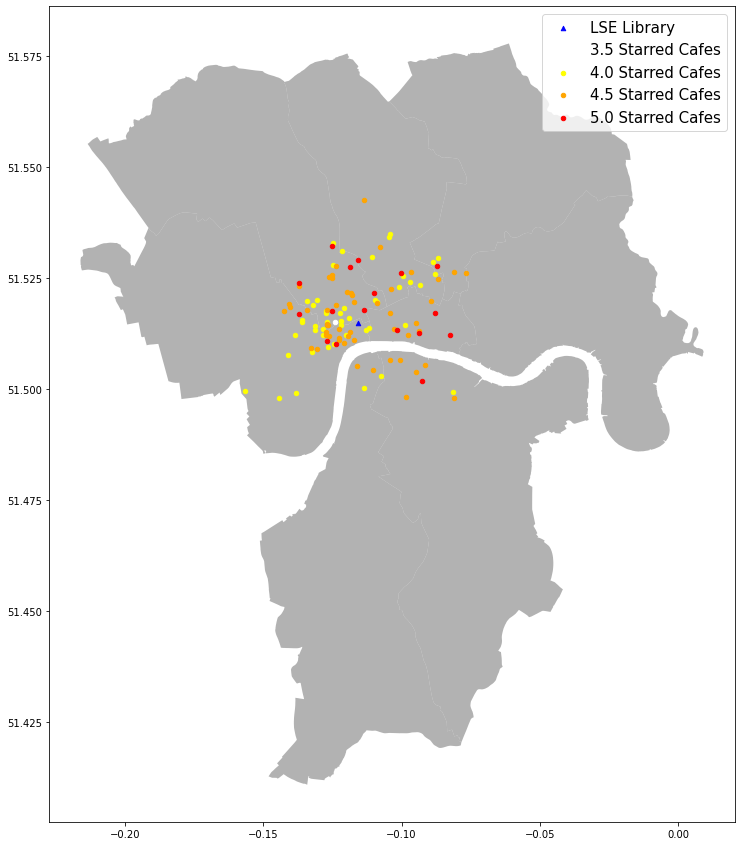

In [18]:
fig,ax = plt.subplots(figsize = (15,15))
lm.plot(ax=ax, alpha=0.6,color="grey")
g_cafes[g_cafes["Name"]=='LSE'].plot(ax=ax, markersize=20, color="blue",marker="^", label="LSE Library")
g_cafes[(g_cafes["Name"]!='LSE') & (g_cafes["Rating"]==3.5)].plot(ax=ax, markersize=20, color="white", label="3.5 Starred Cafes")
g_cafes[(g_cafes["Name"]!='LSE') & (g_cafes["Rating"]==4.0)].plot(ax=ax, markersize=20, color="yellow", label="4.0 Starred Cafes")
g_cafes[(g_cafes["Name"]!='LSE') & (g_cafes["Rating"]==4.5)].plot(ax=ax, markersize=20, color="orange", label="4.5 Starred Cafes")
g_cafes[(g_cafes["Name"]!='LSE') & (g_cafes["Rating"]==5.0)].plot(ax=ax, markersize=20, color="red", label="5.0 Starred Cafes")
plt.legend(prop={"size":15})

## Recommendations

To recommend a student a coffee shop, I decided that the most straightforward way was to have them rank the three most important factors to them, and from there, I would be able to tell them the top three coffee shops that best matched their priorities.

In [19]:
def getsorteddf(df, priorities):
    cols = []
def recommend(cafes):
    choices = ["price","location","rating","peer reviewed"]
    c = []
    p1 = input("Let's find you your perfect coffee shop! What is the most important aspect of a cafe? Choose from: price, location, rating, peer reviewed ").lower()
    while p1 not in choices:
        p1 = input("Oh no! That is not one of the choices. Please enter one of the following: price, location, rating, peer reviewed ")  # loop until input is correct
    c.append(p1)
    p2 = input("What is your second priority? ").lower()
    while p2 not in choices:
        p2 = input("Oh no! That is not one of the choices. Please enter one of the following: price, location, rating, peer reviewed ")  # loop until input is correct
    while p2 in c:
        p2 = input("Oh no! You've already chosen that. Please enter one something new. ")  # loop until input is correct
    c.append(p2)
    p3 = input("What is your third priority? ").lower()
    while p3 not in choices:
        p3 = input("Oh no! That is not one of the choices. Please enter one of the following: price, location, rating, peer reviewed ")  # loop until input is correct
    while p3 in c:
        p3 = input("Oh no! You've already chosen that. Please enter one something new. ")  # loop until input is correct
    c.append(p3)
    
    cols = []
    ascd = []
    for i in range(3):
        if c[i] == "price":
            cols.append("Price")
            ascd.append(True)
        elif c[i] == "location":
            cols.append("Distance")
            ascd.append(True)
        elif c[i] == "rating":
            cols.append("Rating")
            ascd.append(False)
        else:
            cols.append("Reviews")
            ascd.append(False)
    
    sorteddf = cafes.sort_values(cols, ascending=ascd)
    top3 = sorteddf[:3]
    print("My recommendations for you are: ")
    print(top3['Name'])


In [22]:
recommend(cafes)

Let's find you your perfect coffee shop! What is the most important aspect of a cafe? Choose from: price, location, rating, peer reviewed price
What is your second priority? price
Oh no! You've already chosen that. Please enter one something new. location
What is your third priority? price
Oh no! You've already chosen that. Please enter one something new. rating
My recommendations for you are: 
17            Apostrophe
1              Lundenwic
3     Fleet Street Press
Name: Name, dtype: object


My recommendation system will give the best three matches for what the student's priorities are.

## Conclusion

There are no meaningful patterns in the coffee shops surrounding LSE, but their attributes can be used to provide a recommendation to a student based on their priorites.